<a href="https://colab.research.google.com/github/cjy-sc11/2025_ML_final_project/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

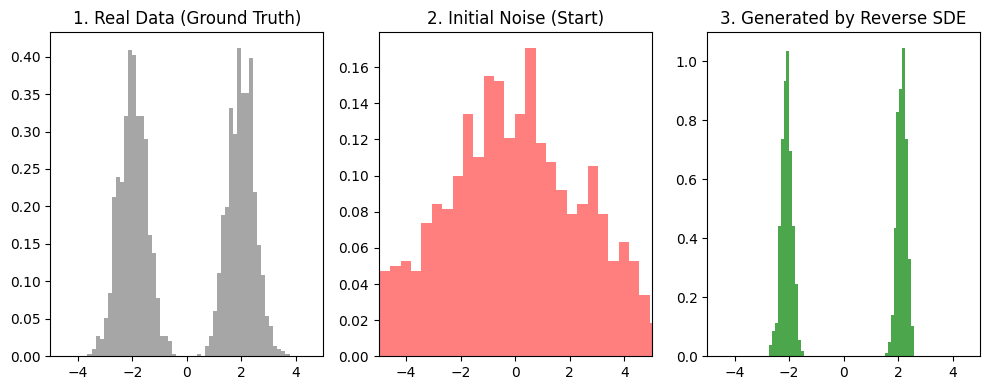

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. 準備真實數據 (雙峰分佈 - 模擬兩個穩定狀態)
# ==========================================
def get_data(batch_size):
    # 50% 機率在 -2 (左峰), 50% 機率在 +2 (右峰)
    modes = torch.randint(0, 2, (batch_size, 1)).float()
    data = (modes * 4 - 2) + torch.randn(batch_size, 1) * 0.5
    return data

# ==========================================
# 2. 定義 Score Network (簡單 MLP)
# ==========================================
class ScoreNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 輸入: x (數據狀態), t (當前噪音程度/時間)
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Softplus(), # Softplus 是一個平滑的 ReLU，適合物理/機率問題
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        # 將 x 和 t 拼接作為輸入
        inp = torch.cat([x, t], dim=1)
        return self.net(inp)

# ==========================================
# 3. 訓練過程 (Denoising Score Matching)
# ==========================================
model = ScoreNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 2000

loss_history = []

for i in range(epochs):
    # A. 取樣真實數據 x0
    x0 = get_data(128)

    # B. 隨機採樣時間 t (噪音強度 sigma)
    # 這裡簡化處理：假設 sigma 直接對應時間 t，範圍 [0.1, 1.0]
    sigma = torch.rand(128, 1) * 0.9 + 0.1

    # C. 前向 SDE：加噪 (Forward Process)
    z = torch.randn_like(x0) # 標準常態雜訊
    perturbed_x = x0 + sigma * z

    # D. 模型預測 Score
    # 理論上 Score = -z / sigma (對於高斯噪音)
    # 我們讓模型去預測這個梯度
    estimated_score = model(perturbed_x, sigma)

    # E. Loss Function: MSE(預測 Score, 真實 Target Score)
    # Target score = -z / sigma
    target_score = -z / sigma
    loss = torch.mean((estimated_score - target_score)**2) * (sigma**2).mean() # sigma^2 為權重平衡

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

# ==========================================
# 4. 生成新數據 (Reverse SDE / Langevin Dynamics)
# ==========================================
# 從純雜訊開始
x_seq = [torch.randn(1000, 1) * 3]

# 逐步降噪 (模擬 Reverse SDE)
# 從大噪音 (sigma=1.0) 走到 小噪音 (sigma=0.1)
sigmas = np.linspace(1.0, 0.1, 50)
delta = sigmas[0] - sigmas[1] # 步長

with torch.no_grad():
    x = x_seq[0].clone()
    for sigma_val in sigmas:
        sigma_tensor = torch.ones_like(x) * sigma_val

        # 取得當前的 Score (梯度方向)
        score = model(x, sigma_tensor)

        # Langevin Dynamics 更新規則 / Euler-Maruyama for Reverse SDE
        # x_new = x_old + step_size * score + noise
        # 這裡簡化實作 Update rule
        step_size = 0.05
        noise = torch.randn_like(x) * np.sqrt(step_size)

        # 往密度高的地方移動 (Score 方向)
        x = x + step_size * score + noise * 0.5

    x_final = x

# ==========================================
# 5. 繪圖結果
# ==========================================
plt.figure(figsize=(10, 4))

# 原始真實分佈
plt.subplot(1, 3, 1)
plt.hist(get_data(2000).numpy(), bins=50, color='gray', alpha=0.7, density=True)
plt.title("1. Real Data (Ground Truth)")
plt.xlim(-5, 5)

# 初始雜訊
plt.subplot(1, 3, 2)
plt.hist(x_seq[0].numpy(), bins=50, color='red', alpha=0.5, density=True)
plt.title("2. Initial Noise (Start)")
plt.xlim(-5, 5)

# AI 生成結果
plt.subplot(1, 3, 3)
plt.hist(x_final.numpy(), bins=50, color='green', alpha=0.7, density=True)
plt.title("3. Generated by Reverse SDE")
plt.xlim(-5, 5)

plt.tight_layout()
plt.show()